## Evaluating the `roberta-base-go_emotions` model

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/samlowe/go_emotions-dataset/blob/main/eval-roberta-base-go_emotions.ipynb)

### Init

In [55]:
%%capture
!pip install datasets transformers pandas matplotlib tqdm --upgrade --quiet
!pip install transformers==4.40.1


In [56]:
import datasets
from transformers import pipeline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

### Load the dataset

We just want the dataset test split here for evaluation

In [57]:
split_name = "test"

dataset_name, dataset_config_name = "go_emotions", "simplified"
dataset_dict = datasets.load_dataset(dataset_name, dataset_config_name)
dataset_dict[split_name][0]

{'text': 'I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!',
 'labels': [25],
 'id': 'eecwqtt'}

In [58]:
labels = dataset_dict[split_name].features["labels"].feature.names
print({i: l for i, l in enumerate(labels)})

{0: 'admiration', 1: 'amusement', 2: 'anger', 3: 'annoyance', 4: 'approval', 5: 'caring', 6: 'confusion', 7: 'curiosity', 8: 'desire', 9: 'disappointment', 10: 'disapproval', 11: 'disgust', 12: 'embarrassment', 13: 'excitement', 14: 'fear', 15: 'gratitude', 16: 'grief', 17: 'joy', 18: 'love', 19: 'nervousness', 20: 'optimism', 21: 'pride', 22: 'realization', 23: 'relief', 24: 'remorse', 25: 'sadness', 26: 'surprise', 27: 'neutral'}


Load into a `y_target` stucture of arrays by label (since we wish to evaluate per label for a multi-label, multi-class dataset like this)

In [59]:
num_items, num_labels = len(dataset_dict[split_name]), len(labels)
y_targets_all = np.zeros((num_items, num_labels), dtype=int)
for i, labels_indices in enumerate(dataset_dict[split_name]["labels"]):
    for label_index in labels_indices:
        y_targets_all[i, label_index] = 1

print(y_targets_all[0:3])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


### Load the model and run it

Load my model

In [60]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# My model checkpoint folder
curriculum_learning_model_path = "outputs/goemotions_transfer2/best_eval_f1_ckpt"  # <-- set the correct checkpoint path here

# Load my tokenizer and model
custom_tokenizer = AutoTokenizer.from_pretrained(curriculum_learning_model_path)
custom_model = AutoModelForSequenceClassification.from_pretrained(curriculum_learning_model_path)

# Create a new classifier pipeline (same settings as original)
curriculum_learning_model = pipeline(
    task="text-classification",
    model=custom_model,
    tokenizer=custom_tokenizer,
    top_k=None,
    function_to_apply="sigmoid",  # since this is multi-label classification
    return_all_scores=True
)

curriculum_learning_model_output = curriculum_learning_model(dataset_dict[split_name]["text"]) 


In [61]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

# My model checkpoint folder
custom_model_path = "outputs/goemotions_notransfer/best_eval_f1_ckpt"  # <-- set the correct checkpoint path here

# Load my tokenizer and model
custom_tokenizer = AutoTokenizer.from_pretrained(custom_model_path)
custom_model = AutoModelForSequenceClassification.from_pretrained(custom_model_path)

# Create a new classifier pipeline (same settings as original)
my_model = pipeline(
    task="text-classification",
    model=custom_model,
    tokenizer=custom_tokenizer,
    top_k=None,
    function_to_apply="sigmoid",  # since this is multi-label classification
    return_all_scores=True
)

my_model_output = my_model(dataset_dict[split_name]["text"]) 


Loading in a multi-label, multi-class classifier model based on Roberta-base

In [62]:
classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

/home/vipuser/miniconda3/envs/emoenv/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Very simple to then run the pipeline on the dataset test split.
- c.5k items so can be run on a decent CPU in a few minutes (E.g. 3.5 mins on a 11th gen i7 laptop)
- (will take signifcantly longer on a free Colab instance's 2 core CPU)
- or of course via a GPU in seconds. 

In [63]:
base_model_outputs = classifier(dataset_dict[split_name]["text"]) 

print(dataset_dict[split_name]["text"][0])
print(base_model_outputs[0])

I’m really sorry about your situation :( Although I love the names Sapphira, Cirilla, and Scarlett!
[{'label': 'remorse', 'score': 0.678300678730011}, {'label': 'sadness', 'score': 0.5406180024147034}, {'label': 'love', 'score': 0.3608132600784302}, {'label': 'caring', 'score': 0.05576622858643532}, {'label': 'disappointment', 'score': 0.036921314895153046}, {'label': 'approval', 'score': 0.03364568203687668}, {'label': 'gratitude', 'score': 0.031087186187505722}, {'label': 'admiration', 'score': 0.018729250878095627}, {'label': 'grief', 'score': 0.018079761415719986}, {'label': 'optimism', 'score': 0.015966985374689102}, {'label': 'disapproval', 'score': 0.015757175162434578}, {'label': 'realization', 'score': 0.013122462667524815}, {'label': 'desire', 'score': 0.011346070095896721}, {'label': 'curiosity', 'score': 0.010657965205609798}, {'label': 'confusion', 'score': 0.010225102305412292}, {'label': 'anger', 'score': 0.008085090667009354}, {'label': 'embarrassment', 'score': 0.00747

The model gave us floating point outputs for each label for each item, as a list of dicts. We need to arrange these into an array to be able to easily compare them with the dataset values. These values are sometimes known as probabilities (or `probas` for short) - but note, although these values are quantitative and can be compared to an extent (as we will), they are not really probabilities in any real statistical sense. 

We still need to convert these to binary prediction (`preds`) to be able to compare them to the `y_target` values from the dataset, but since the best threshold value to use to convert them is not yet known, we'll keep the float values.

In [64]:
base_y_probas_all = np.zeros((num_items, num_labels), dtype=float)
for i, item_probas in enumerate(base_model_outputs):
    for item_proba in item_probas:
        label, score = item_proba["label"], item_proba["score"]
        label_index = labels.index(label)
        base_y_probas_all[i, label_index] = score

In [65]:
my_y_probas_all = np.zeros((num_items, num_labels), dtype=float)
for i, item_probas in enumerate(my_model_output):
    for item_proba in item_probas:
        label, score = item_proba["label"], item_proba["score"]
        label_index = labels.index(label)
        my_y_probas_all[i, label_index] = score

In [68]:
# Extract label mapping
id2label = custom_model.config.id2label  # dictionary: str → label name (e.g., "0": "fear")

# If keys are strings (as they should be), convert them
id2label = {f"LABEL_{k}": v for k, v in id2label.items()}

# Allocate prediction matrix
curriculum_y_probas_all = np.zeros((num_items, num_labels), dtype=float)

# Fill it
for i, item_probas in enumerate(curriculum_learning_model_output):
    for item_proba in item_probas:
        label_raw = item_proba["label"]  # e.g., "LABEL_24"
        score = item_proba["score"]

        # Translate to readable label name
        label = id2label.get(label_raw, None)
        if label is None:
            raise ValueError(f"Unknown label: {label_raw}")

        label_index = labels.index(label)
        curriculum_y_probas_all[i, label_index] = score


In [ ]:
i = 3856
print(dataset_dict[split_name][i])
print(np.round(base_y_probas_all[i], 3).tolist())
top = np.argmax(base_y_probas_all[i])
print(f"Top label proba is label number {top} ({labels[top]}): {base_y_probas_all[i][top]}")

{'text': 'Damn, still hoping...', 'labels': [20], 'id': 'edm34qc'}
[0.002, 0.003, 0.008, 0.022, 0.011, 0.015, 0.002, 0.002, 0.052, 0.01, 0.01, 0.002, 0.001, 0.002, 0.002, 0.005, 0.001, 0.002, 0.002, 0.001, 0.824, 0.001, 0.007, 0.001, 0.003, 0.003, 0.002, 0.157]
Top label proba is label number 20 (optimism): 0.8238562345504761


### Evalutation

We'll use good old SKLearn for evaluation here because it's super well known and simple. You could use something else, such as Huggingface Evaluate if you prefer.

In [69]:
from sklearn import metrics

We can see the metrics at a threshold of 0.5 (which intuitively seems like the right one to use).

Should ignore accuracy because it isn't really helpful when applied per item for a multi-label dataset E.g. if there are 3 positive labels for a particular item but the model only gets 2 of them, accuracy will treat that as a 0/fail, not a partial success.

In [70]:
threshold = 0.5
y_preds_all = base_y_probas_all > threshold

print("baseline Model (macro)")
print("===============")
print(f"Accuracy: {metrics.accuracy_score(y_targets_all, y_preds_all):.3f}")
print(f"Precision: {metrics.precision_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"Recall: {metrics.recall_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"F1: {metrics.f1_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")

baseline Model (macro)
Accuracy: 0.474
Precision: 0.575
Recall: 0.396
F1: 0.450


Evaluate my model

In [71]:
threshold = 0.5
y_preds_all = curriculum_y_probas_all > threshold

print("Curriculum Model (macro)")
print("===============")
print(f"Accuracy: {metrics.accuracy_score(y_targets_all, y_preds_all):.3f}")
print(f"Precision: {metrics.precision_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"Recall: {metrics.recall_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"F1: {metrics.f1_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")

Curriculum Model (macro)
Accuracy: 0.468
Precision: 0.539
Recall: 0.463
F1: 0.477


In [72]:
threshold = 0.5
y_preds_all = my_y_probas_all > threshold

print("My Model (macro)")
print("===============")
print(f"Accuracy: {metrics.accuracy_score(y_targets_all, y_preds_all):.3f}")
print(f"Precision: {metrics.precision_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"Recall: {metrics.recall_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")
print(f"F1: {metrics.f1_score(y_targets_all, y_preds_all, average='macro', zero_division=0):.3f}")

My Model (macro)
Accuracy: 0.468
Precision: 0.546
Recall: 0.466
F1: 0.494


And now per label (which is more meaningful for a multi-label, multiclass dataset such as this)

Note the support for certain labels is tiny - grief has 6 positives in the dataset test split (out of c5.4k items). So measurement of the test set for such labels is meaningless, and anyway (given there is a similarly tiny number in the training split) unsurprisingly the model fails to predict positives for such labels since it's been trained on overwhelmling negative examples.

We really should prune any labels with less than (for example) 50 positive examples in the training split (which is significantly bigger than the test split we are looking at here), or we should augment the data synthetically for these tiny/scarce labels to allow the model to learn these signals.

However, they have been left in here for visibility.

In [73]:
def calc_label_metrics(label, y_targets, y_preds, threshold):
    return {
        "label": label,
        "accuracy": metrics.accuracy_score(y_targets, y_preds),
        "precision": metrics.precision_score(y_targets, y_preds, zero_division=0),
        "recall": metrics.recall_score(y_targets, y_preds, zero_division=0),
        "f1": metrics.f1_score(y_targets, y_preds, zero_division=0),
        "mcc": metrics.matthews_corrcoef(y_targets, y_preds),
        "support": y_targets.sum(),
        "threshold": threshold,
    }

In [74]:
threshold = 0.5
y_preds_all = (base_y_probas_all > threshold).astype(int)

results = []
for label_index, label in enumerate(labels):
    y_targets, y_preds = y_targets_all[:, label_index], y_preds_all[:, label_index]
    results.append(calc_label_metrics(label, y_targets, y_preds, threshold))

per_label_results = pd.DataFrame(results, index=labels)
display(per_label_results.drop(columns=["label"]).round(3))

,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.946,0.725,0.675,0.699,0.670,504,0.5
amusement,0.982,0.790,0.871,0.829,0.821,264,0.5
anger,0.970,0.652,0.379,0.479,0.483,198,0.5
annoyance,0.940,0.472,0.159,0.238,0.250,320,0.5
approval,0.942,0.609,0.302,0.404,0.403,351,0.5
caring,0.973,0.448,0.319,0.372,0.364,135,0.5
confusion,0.972,0.500,0.431,0.463,0.450,153,0.5
curiosity,0.950,0.537,0.356,0.428,0.412,284,0.5
desire,0.987,0.630,0.410,0.496,0.502,83,0.5
disappointment,0.974,0.625,0.199,0.302,0.343,151,0.5


Note, should probably ignore accuracy metric again, but in this case at the per-label level a multi-label dataset has a huge number of true negatives which make the accuracy figure pretty meaningless. E.g. in a situation where there are 10 positive items and 990 negative items, if a model simply predicts negative for everything, its accuracy figure still appears very high (0.99) even though its clearly not performing to a useful level.

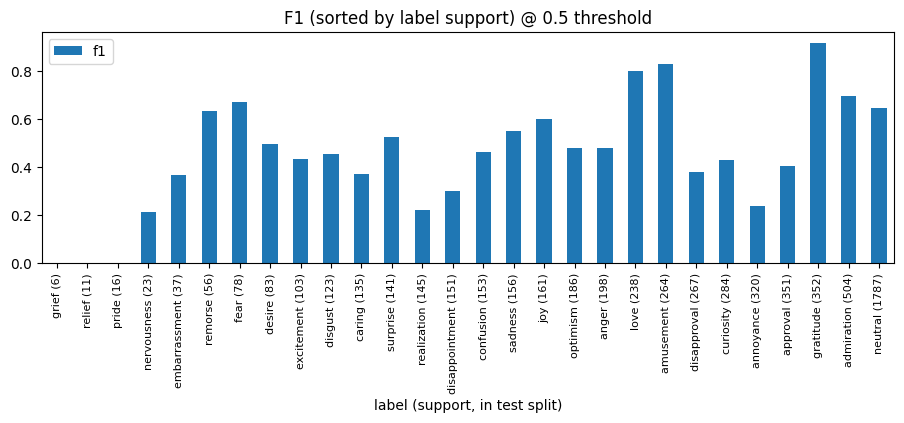

In [75]:
per_label_results["label (support)"] = (
    per_label_results.index + " (" + per_label_results["support"].astype(str) + ")"
)
ax = per_label_results.sort_values(by="support").plot.bar(
    x="label (support)",
    y=["f1"],
    rot=90,
    title="F1 (sorted by label support) @ 0.5 threshold",
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()

In [76]:
threshold = 0.5
y_preds_all = (my_y_probas_all > threshold).astype(int)

results = []
for label_index, label in enumerate(labels):
    y_targets, y_preds = y_targets_all[:, label_index], y_preds_all[:, label_index]
    results.append(calc_label_metrics(label, y_targets, y_preds, threshold))

per_label_results = pd.DataFrame(results, index=labels)
display(per_label_results.drop(columns=["label"]).round(3))

,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.936,0.631,0.746,0.684,0.651,504,0.5
amusement,0.981,0.786,0.833,0.809,0.799,264,0.5
anger,0.967,0.574,0.409,0.478,0.469,198,0.5
annoyance,0.930,0.394,0.341,0.365,0.329,320,0.5
approval,0.930,0.446,0.330,0.380,0.348,351,0.5
caring,0.974,0.472,0.370,0.415,0.405,135,0.5
confusion,0.972,0.500,0.366,0.423,0.414,153,0.5
curiosity,0.942,0.463,0.644,0.539,0.517,284,0.5
desire,0.987,0.636,0.422,0.507,0.512,83,0.5
disappointment,0.969,0.414,0.238,0.303,0.300,151,0.5


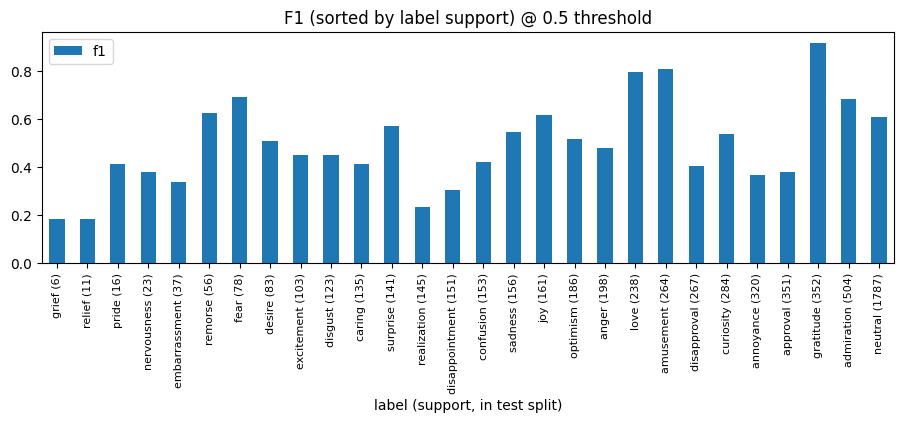

In [77]:
per_label_results["label (support)"] = (
    per_label_results.index + " (" + per_label_results["support"].astype(str) + ")"
)
ax = per_label_results.sort_values(by="support").plot.bar(
    x="label (support)",
    y=["f1"],
    rot=90,
    title="F1 (sorted by label support) @ 0.5 threshold",
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()

Per-class F1 scores comparison (sorted by label frequency):


,F1 (Base),F1 (Ours),Support
label,,,
grief,0.000,0.182,6
relief,0.000,0.182,11
pride,0.000,0.412,16
nervousness,0.214,0.379,23
embarrassment,0.367,0.340,37
remorse,0.636,0.627,56
fear,0.671,0.693,78
desire,0.496,0.507,83
excitement,0.435,0.449,103


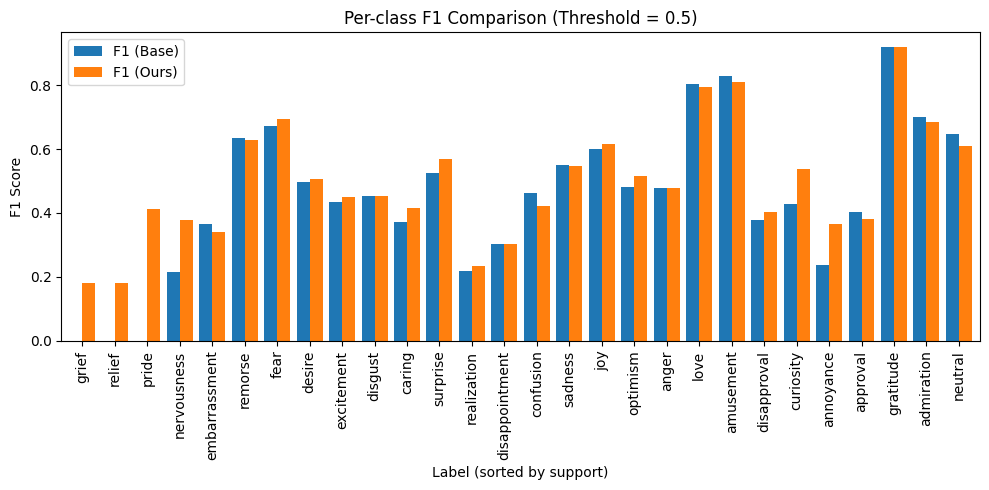

Your model outperforms the base model in 16 out of 28 emotion categories.


In [85]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics

def calc_label_metrics(label, y_targets, y_preds, threshold):
    return {
        "label": label,
        "f1": metrics.f1_score(y_targets, y_preds, zero_division=0),
        "support": y_targets.sum(),
        "threshold": threshold,
    }

# --- Compute per-class F1 for base model ---
threshold = 0.5
y_preds_all_base = (base_y_probas_all > threshold).astype(int)
results_base = []
for label_index, label in enumerate(labels):
    y_targets, y_preds = y_targets_all[:, label_index], y_preds_all_base[:, label_index]
    results_base.append(calc_label_metrics(label, y_targets, y_preds, threshold))
df_base = pd.DataFrame(results_base).set_index("label")

# --- Compute per-class F1 for your model ---
y_preds_all_mine = (my_y_probas_all > threshold).astype(int)
results_mine = []
for label_index, label in enumerate(labels):
    y_targets, y_preds = y_targets_all[:, label_index], y_preds_all_mine[:, label_index]
    results_mine.append(calc_label_metrics(label, y_targets, y_preds, threshold))
df_mine = pd.DataFrame(results_mine).set_index("label")

# --- Combine into one table ---
f1_compare = pd.DataFrame({
    "F1 (Base)": df_base["f1"].round(3),
    "F1 (Ours)": df_mine["f1"].round(3),
    "Support": df_base["support"]
})
f1_compare_sorted = f1_compare.sort_values("Support")

# --- Display the table ---
print("Per-class F1 scores comparison (sorted by label frequency):")
display(f1_compare_sorted)

# --- Plot F1 side-by-side ---
ax = f1_compare_sorted[["F1 (Base)", "F1 (Ours)"]].plot.bar(
    figsize=(10, 5),
    width=0.8,
    rot=90,
    title="Per-class F1 Comparison (Threshold = 0.5)"
)
ax.set_xlabel("Label (sorted by support)")
ax.set_ylabel("F1 Score")
ax.tick_params(axis='x', labelsize=10)
plt.tight_layout()
plt.show()

# --- Count how many labels we win ---
win_count = (f1_compare["F1 (Ours)"] > f1_compare["F1 (Base)"]).sum()
total_labels = len(f1_compare)
print(f"Your model outperforms the base model in {win_count} out of {total_labels} emotion categories.")


We can recreate dataset-wide metrics from per-label metrics, which will prove useful later.

In [ ]:
def dataset_wide_metrics(df):
    simple_mean = {
        m: round(df[m].mean(), 3)
        for m in ["precision", "recall", "f1", "mcc"]
    }
    print("Simple mean of labels:", simple_mean)
    weighted = {
        m: round(sum(df[m] * df["support"]) / df["support"].sum(), 3)
        for m in ["precision", "recall", "f1", "mcc"]
    }
    print("Weighted average (using support):", weighted)
    return simple_mean, weighted

_ = dataset_wide_metrics(per_label_results)

Simple mean of labels: {'precision': np.float64(0.575), 'recall': np.float64(0.396), 'f1': np.float64(0.45), 'mcc': np.float64(0.451)}
Weighted average (using support): {'precision': np.float64(0.662), 'recall': np.float64(0.511), 'f1': np.float64(0.564), 'mcc': np.float64(0.519)}


In [ ]:
_ = dataset_wide_metrics(custom_per_label_results)


Simple mean of labels: {'precision': np.float64(0.539), 'recall': np.float64(0.463), 'f1': np.float64(0.477), 'mcc': np.float64(0.471)}
Weighted average (using support): {'precision': np.float64(0.626), 'recall': np.float64(0.523), 'f1': np.float64(0.555), 'mcc': np.float64(0.509)}


So, now lets do a crude search for how the metrics vary by threshold, rather than naively setting it at 0.5 as above

In [ ]:
threshold_results = {}
for t in tqdm(range(5, 100, 5)):
    threshold = t / 100
    y_preds_all = (y_probas_all > threshold).astype(int)
    threshold_results[threshold] = []
    for label_index, label in enumerate(labels):
        y_targets, y_preds = y_targets_all[:, label_index], y_preds_all[:, label_index]
        threshold_results[threshold].append(calc_label_metrics(label, y_targets, y_preds, threshold))

100%|██████████| 19/19 [00:03<00:00,  5.96it/s]


In [ ]:
metric_name = "f1"
best = {label: {metric_name: -1, "result": None} for label in labels}
for threshold, results in threshold_results.items():
    for result in results:
        label = result["label"]
        if result[metric_name] > best[label][metric_name]:
            best[label] = {metric_name: result[metric_name], "result": result}

results = [b["result"] for b in best.values()]
per_label_threshold_results = pd.DataFrame(results, index=[result["label"] for result in results])
display(per_label_threshold_results.drop(columns=["label"]).round(3))

,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.940,0.651,0.776,0.708,0.678,504,0.25
amusement,0.982,0.781,0.890,0.832,0.825,264,0.45
anger,0.959,0.454,0.601,0.517,0.502,198,0.15
annoyance,0.864,0.243,0.619,0.349,0.328,320,0.10
approval,0.926,0.432,0.442,0.437,0.397,351,0.30
caring,0.972,0.426,0.385,0.405,0.391,135,0.40
confusion,0.974,0.548,0.412,0.470,0.462,153,0.55
curiosity,0.943,0.473,0.711,0.568,0.552,284,0.25
desire,0.985,0.518,0.530,0.524,0.516,83,0.25
disappointment,0.974,0.562,0.298,0.390,0.398,151,0.40


Charting it

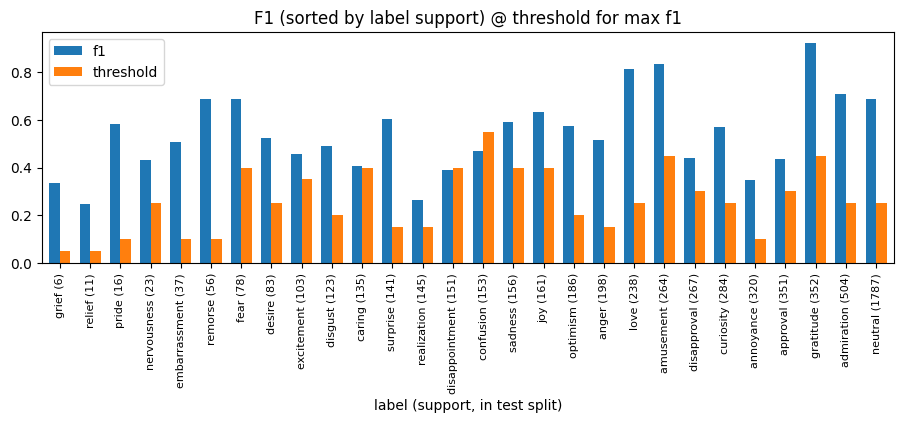

In [ ]:
per_label_threshold_results["label (support)"] = (
    per_label_threshold_results["label"] + " (" + per_label_threshold_results["support"].astype(str) + ")"
)
ax = per_label_threshold_results.sort_values(by="support").plot.bar(
    x='label (support)',
    y=["f1", "threshold"],
    rot=90,
    title="F1 (sorted by label support) @ threshold for max f1",
    width=0.7,
    figsize=(11,3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()

In [ ]:
custom_threshold_results = {}
for t in tqdm(range(5, 100, 5)):
    threshold = t / 100
    custom_preds_thresh = (custom_probas > threshold).astype(int)
    custom_threshold_results[threshold] = []
    for label_index, label in enumerate(labels):
        y_targets = y_targets_all[:, label_index]
        y_preds = custom_preds_thresh[:, label_index]
        custom_threshold_results[threshold].append(
            calc_label_metrics(label, y_targets, y_preds, threshold)
        )


100%|██████████| 19/19 [00:03<00:00,  5.93it/s]


In [ ]:
# Define the metric to optimize
metric_name = "f1"

# Initialize best results storage
best_custom = {label: {metric_name: -1, "result": None} for label in labels}

# Find the best threshold (per label) that gives the highest F1 score
for threshold, results in custom_threshold_results.items():
    for result in results:
        label = result["label"]
        score = result.get(metric_name, -1)
        if score > best_custom[label][metric_name]:
            best_custom[label] = {
                metric_name: score,
                "result": result
            }

# Filter out labels with no valid result
filtered_results = [
    b["result"] for b in best_custom.values() if b["result"] is not None
]
filtered_index = [
    b["result"]["label"] for b in best_custom.values() if b["result"] is not None
]

# Create the final DataFrame
custom_per_label_threshold_results = pd.DataFrame(
    filtered_results,
    index=filtered_index
)

# Display the rounded per-label result table
display(custom_per_label_threshold_results.drop(columns=["label"]).round(3))


,accuracy,precision,recall,f1,mcc,support,threshold
admiration,0.940,0.667,0.714,0.690,0.657,504,0.50
amusement,0.980,0.742,0.905,0.816,0.810,264,0.55
anger,0.958,0.439,0.510,0.472,0.452,198,0.45
annoyance,0.924,0.353,0.356,0.355,0.314,320,0.25
approval,0.932,0.465,0.376,0.416,0.382,351,0.30
caring,0.974,0.477,0.393,0.431,0.420,135,0.55
confusion,0.963,0.383,0.516,0.440,0.426,153,0.25
curiosity,0.944,0.479,0.768,0.590,0.580,284,0.35
desire,0.986,0.540,0.566,0.553,0.546,83,0.25
disappointment,0.963,0.311,0.272,0.290,0.271,151,0.40


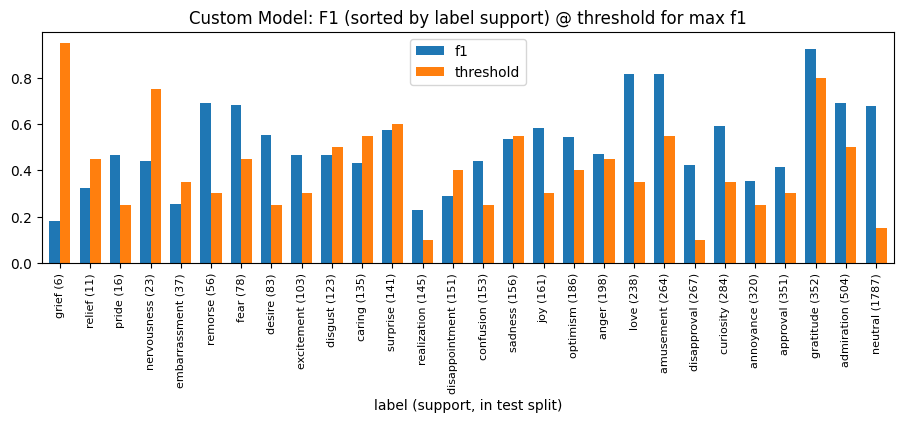

In [ ]:
custom_per_label_threshold_results["label (support)"] = (
    custom_per_label_threshold_results["label"] + 
    " (" + custom_per_label_threshold_results["support"].astype(str) + ")"
)

ax = custom_per_label_threshold_results.sort_values(by="support").plot.bar(
    x='label (support)',
    y=["f1", "threshold"],
    rot=90,
    title="Custom Model: F1 (sorted by label support) @ threshold for max f1",
    width=0.7,
    figsize=(11, 3),
)
ax.tick_params(axis='x', which='major', labelsize=8)
ax.axes.xaxis.label.set_text(f"label (support, in {split_name} split)")
plt.show()


In [ ]:
# Ensure we align both DataFrames on the same label index
common_labels = list(set(per_label_threshold_results.index) & set(custom_per_label_threshold_results.index))
baseline_f1 = per_label_threshold_results.loc[common_labels, "f1"]
custom_f1 = custom_per_label_threshold_results.loc[common_labels, "f1"]

# Combine into a comparison DataFrame
f1_comparison_df = pd.DataFrame({
    "f1_baseline": baseline_f1,
    "f1_custom": custom_f1
})
f1_comparison_df["diff (custom - baseline)"] = f1_comparison_df["f1_custom"] - f1_comparison_df["f1_baseline"]

# Display comparison
display(f1_comparison_df.round(3))

# Summary statistics
print("Mean F1:")
print(f"Baseline: {baseline_f1.mean():.3f}")
print(f"Custom:   {custom_f1.mean():.3f}")
print(f"Difference: {(custom_f1.mean() - baseline_f1.mean()):.3f}")


,f1_baseline,f1_custom,diff (custom - baseline)
relief,0.246,0.323,0.077
disappointment,0.390,0.290,-0.100
desire,0.524,0.553,0.029
fear,0.689,0.682,-0.007
joy,0.634,0.582,-0.052
disapproval,0.439,0.423,-0.017
grief,0.333,0.182,-0.152
nervousness,0.432,0.439,0.007
realization,0.266,0.229,-0.037
neutral,0.688,0.677,-0.011


Mean F1:
Baseline: 0.541
Custom:   0.512
Difference: -0.029


Note how the best performing threshold (when measured by maximizing f1) is always a lower threshold than the 0.5 assumed before. This is likely because there are so mny true negatives in the dataset (as is often the case with multi-label, multi-class datasets).

As you'd expect precision takes a dip vs before as the model is predicting positive more often, but to a lesser degree than recall climbs, causing F1 to overall increase (since F1 is the harmonic mean of precision and recall).

The most extreme examples being the labels with the smallest support (e.g. grief) where the smallest threshold tried (0.05) is the one that cajoles the model into finally giving some positives and hence getting valid precision and recall scores that can't do if they never predict positive.

Various techniques could be used to increase the probas so these low thresholds were not the best, such as boosting/duplicating the true positives in the training set, data augmentation, or a linear layer to boost the proba output, but simply using a label-bespoke threshold here gives us a view of the perf of the model as it is. 

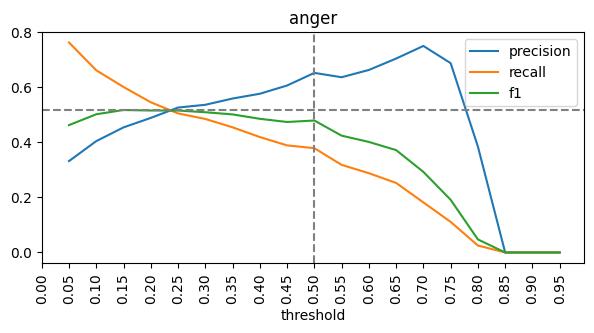

In [ ]:
_label_name = "anger"
label_per_threshold_results = []
for threshold, results in threshold_results.items():
    for result in results:
        if result["label"] == _label_name:
            label_per_threshold_results.append(result)

label_per_threshold_results = pd.DataFrame(
    label_per_threshold_results, index=[r["threshold"] for r in label_per_threshold_results]
)
ax = label_per_threshold_results.plot.line(
    x="threshold", y=["precision", "recall", "f1"], rot=90, title=_label_name, figsize=(7,3)
)
ax.axvline(0.5, color='gray', linestyle='--')
ax.axhline(label_per_threshold_results["f1"].max(), color="gray", linestyle="--")
ax.xaxis.set_ticks(np.arange(0, 1, 0.05))
plt.show()

In [ ]:
print("### Threshold set to arbitary 0.5")
_before = dataset_wide_metrics(per_label_results)
print()
print("### Threshold from per label search (for best F1 score)")
_after = dataset_wide_metrics(per_label_threshold_results)

print()
percentage = (_after[0]["f1"] - _before[0]["f1"]) / _before[0]["f1"] * 100
print(f"F1 (simple mean) improved by {round(percentage, 1)}%")
percentage = (_after[1]["f1"] - _before[1]["f1"]) / _before[0]["f1"] * 100
print(f"F1 (weighted) improved by {round(percentage, 1)}%")

### Threshold set to arbitary 0.5
Simple mean of labels: {'precision': np.float64(0.575), 'recall': np.float64(0.396), 'f1': np.float64(0.45), 'mcc': np.float64(0.451)}
Weighted average (using support): {'precision': np.float64(0.662), 'recall': np.float64(0.511), 'f1': np.float64(0.564), 'mcc': np.float64(0.519)}

### Threshold from per label search (for best F1 score)
Simple mean of labels: {'precision': np.float64(0.542), 'recall': np.float64(0.577), 'f1': np.float64(0.541), 'mcc': np.float64(0.53)}
Weighted average (using support): {'precision': np.float64(0.572), 'recall': np.float64(0.677), 'f1': np.float64(0.611), 'mcc': np.float64(0.55)}

F1 (simple mean) improved by 20.2%
F1 (weighted) improved by 10.4%


### Dataset constraints on the model performance

Some labels (E.g. gratitude) when considered independently perform very strongly with F1 around 0.9, whilst others (E.g. relief) perform very poorly. 

This is a challenging dataset. Labels such as relief do have much fewer examples in the training data (less than 100 out of the 40k+, and only 11 in the test split).

But there is also some ambiguity and/or labelling errors visible in the training data of go_emotions that is suspected to constrain the performance. Data cleaning on the dataset to reduce some of the mistakes, ambiguity, conflicts and duplication in the labelling would produce a higher performing model.